## HW6 Code (be sure to run this first)

In [ ]:
# From set 6 solution code
import os
import re
import random
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib import animation
from matplotlib.animation import FuncAnimation
import time

In [ ]:
class HiddenMarkovModel:
    '''
    Class implementation of Hidden Markov Models.
    '''

    def __init__(self, A, O):
        '''
        Initializes an HMM. Assumes the following:
            - States and observations are integers starting from 0. 
            - There is a start state (see notes on A_start below). There
              is no integer associated with the start state, only
              probabilities in the vector A_start.
            - There is no end state. 

        Arguments:
            A:          Transition matrix with dimensions L x L.
                        The (i, j)^th element is the probability of
                        transitioning from state i to state j. Note that
                        this does not include the starting probabilities.

            O:          Observation matrix with dimensions L x D.
                        The (i, j)^th element is the probability of
                        emitting observation j given state i.

        Parameters:
            L:          Number of states.

            D:          Number of observations.
            
            A:          The transition matrix.
            
            O:          The observation matrix.
            
            A_start:    Starting transition probabilities. The i^th element
                        is the probability of transitioning from the start
                        state to state i. For simplicity, we assume that
                        this distribution is uniform.
        '''

        self.L = len(A)
        self.D = len(O[0])
        self.A = A
        self.O = O
        self.A_start = [1. / self.L for _ in range(self.L)]


    def viterbi(self, x):
        '''
        Uses the Viterbi algorithm to find the max probability state 
        sequence corresponding to a given input sequence.

        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.

        Returns:
            max_seq:    Output sequence corresponding to x with the highest
                        probability.
        '''

        M = len(x)      # Length of sequence.

        # The (i, j)^th elements of probs and seqs are the max probability
        # of the prefix of length i ending in state j and the prefix
        # that gives this probability, respectively.
        #
        # For instance, probs[1][0] is the probability of the prefix of
        # length 1 ending in state 0.
        probs = [[0. for _ in range(self.L)] for _ in range(M + 1)]
        seqs = [['' for _ in range(self.L)] for _ in range(M + 1)]

        # Calculate initial prefixes and probabilities.
        for curr in range(self.L):
            probs[1][curr] = self.A_start[curr] * self.O[curr][x[0]]
            seqs[1][curr] = str(curr)

        # Calculate best prefixes and probabilities throughout sequence.
        for t in range(2, M + 1):
            # Iterate over all possible current states.
            for curr in range(self.L):
                max_prob = float("-inf")
                max_prefix = ''

                # Iterate over all possible previous states to find one
                # that would maximize the probability of the current state.
                for prev in range(self.L):
                    curr_prob = probs[t - 1][prev] \
                                * self.A[prev][curr] \
                                * self.O[curr][x[t - 1]]

                    # Continually update max probability and prefix.
                    if curr_prob >= max_prob:
                        max_prob = curr_prob
                        max_prefix = seqs[t - 1][prev]

                # Store the max probability and prefix.
                probs[t][curr] = max_prob
                seqs[t][curr] = max_prefix + str(curr)

        # Find the index of the max probability of a sequence ending in x^M
        # and the corresponding output sequence.
        max_i = max(enumerate(probs[-1]), key=lambda x: x[1])[0]
        max_seq = seqs[-1][max_i]

        return max_seq


    def forward(self, x, normalize=False):
        '''
        Uses the forward algorithm to calculate the alpha probability
        vectors corresponding to a given input sequence.

        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.

            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.

        Returns:
            alphas:     Vector of alphas.

                        The (i, j)^th element of alphas is alpha_j(i),
                        i.e. the probability of observing prefix x^1:i
                        and state y^i = j.

                        e.g. alphas[1][0] corresponds to the probability
                        of observing x^1:1, i.e. the first observation,
                        given that y^1 = 0, i.e. the first state is 0.
        '''

        M = len(x)      # Length of sequence.
        alphas = [[0. for _ in range(self.L)] for _ in range(M + 1)]

        # Note that alpha_j(0) is already correct for all j's.
        # Calculate alpha_j(1) for all j's.
        for curr in range(self.L):
            alphas[1][curr] = self.A_start[curr] * self.O[curr][x[0]]

        # Calculate alphas throughout sequence.
        for t in range(1, M):
            # Iterate over all possible current states.
            for curr in range(self.L):
                prob = 0

                # Iterate over all possible previous states to accumulate
                # the probabilities of all paths from the start state to
                # the current state.
                for prev in range(self.L):
                    prob += alphas[t][prev] \
                            * self.A[prev][curr] \
                            * self.O[curr][x[t]]

                # Store the accumulated probability.
                alphas[t + 1][curr] = prob

            if normalize:
                norm = sum(alphas[t + 1])
                for curr in range(self.L):
                    alphas[t + 1][curr] /= norm

        return alphas


    def backward(self, x, normalize=False):
        '''
        Uses the backward algorithm to calculate the beta probability
        vectors corresponding to a given input sequence.

        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.

            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.

        Returns:
            betas:      Vector of betas.

                        The (i, j)^th element of betas is beta_j(i), i.e.
                        the probability of observing prefix x^(i+1):M and
                        state y^i = j.

                        e.g. betas[M][0] corresponds to the probability
                        of observing x^M+1:M, i.e. no observations,
                        given that y^M = 0, i.e. the last state is 0.
        '''

        M = len(x)      # Length of sequence.
        betas = [[0. for _ in range(self.L)] for _ in range(M + 1)]

        # Initialize initial betas.
        for curr in range(self.L):
            betas[-1][curr] = 1

        # Calculate betas throughout sequence.
        for t in range(-1, -M - 1, -1):
            # Iterate over all possible current states.
            for curr in range(self.L):
                prob = 0

                # Iterate over all possible next states to accumulate
                # the probabilities of all paths from the end state to
                # the current state.
                for nxt in range(self.L):
                    if t == -M:
                        prob += betas[t][nxt] \
                                * self.A_start[nxt] \
                                * self.O[nxt][x[t]]

                    else:
                        prob += betas[t][nxt] \
                                * self.A[curr][nxt] \
                                * self.O[nxt][x[t]]

                # Store the accumulated probability.
                betas[t - 1][curr] = prob

            if normalize:
                norm = sum(betas[t - 1])
                for curr in range(self.L):
                    betas[t - 1][curr] /= norm

        return betas


    def supervised_learning(self, X, Y):
        '''
        Trains the HMM using the Maximum Likelihood closed form solutions
        for the transition and observation matrices on a labeled
        datset (X, Y). Note that this method does not return anything, but
        instead updates the attributes of the HMM object.

        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of variable-length lists, consisting of integers 
                        ranging from 0 to D - 1. In other words, a list of
                        lists.

            Y:          A dataset consisting of state sequences in the form
                        of lists of variable length, consisting of integers 
                        ranging from 0 to L - 1. In other words, a list of
                        lists.

                        Note that the elements in X line up with those in Y.
        '''

        # Calculate each element of A using the M-step formulas.
        for curr in range(self.L):
            for nxt in range(self.L):
                num = 0.
                den = 0.

                for i in range(len(X)):
                    x = X[i]
                    y = Y[i]
                    M = len(x)
        
                    num += len([1 for i in range(M - 1) \
                                if y[i] == curr and y[i + 1] == nxt])
                    den += len([1 for i in range(M - 1) if y[i] == curr])

                self.A[curr][nxt] = num / den

        # Calculate each element of O using the M-step formulas.
        for curr in range(self.L):
            for xt in range(self.D):
                num = 0.
                den = 0.

                for i in range(len(X)):
                    x = X[i]
                    y = Y[i]
                    M = len(x)
        
                    num += len([1 for i in range(M) \
                                if y[i] == curr and x[i] == xt])
                    den += len([1 for i in range(M) if y[i] == curr])

                self.O[curr][xt] = num / den


    def unsupervised_learning(self, X, N_iters):
        '''
        Trains the HMM using the Baum-Welch algorithm on an unlabeled
        datset X. Note that this method does not return anything, but
        instead updates the attributes of the HMM object.

        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of variable-length lists, consisting of integers ranging
                        from 0 to D - 1. In other words, a list of lists.

            N_iters:    The number of iterations to train on.
        '''

        # Note that a comment starting with 'E' refers to the fact that
        # the code under the comment is part of the E-step.

        # Similarly, a comment starting with 'M' refers to the fact that
        # the code under the comment is part of the M-step.

        for iteration in range(1, N_iters + 1):
            # if iteration % 10 == 0:
            #     print("Iteration: " + str(iteration))

            # Numerator and denominator for the update terms of A and O.
            A_num = [[0. for i in range(self.L)] for j in range(self.L)]
            O_num = [[0. for i in range(self.D)] for j in range(self.L)]
            A_den = [0. for i in range(self.L)]
            O_den = [0. for i in range(self.L)]

            # For each input sequence:
            for x in X:
                M = len(x)
                # Compute the alpha and beta probability vectors.
                alphas = self.forward(x, normalize=True)
                betas = self.backward(x, normalize=True)

                # E: Update the expected observation probabilities for a
                # given (x, y).
                # The i^th index is P(y^t = i, x).
                for t in range(1, M + 1):
                    P_curr = [0. for _ in range(self.L)]
                    
                    for curr in range(self.L):
                        P_curr[curr] = alphas[t][curr] * betas[t][curr]

                    # Normalize the probabilities.
                    norm = sum(P_curr)
                    for curr in range(len(P_curr)):
                        P_curr[curr] /= norm

                    for curr in range(self.L):
                        if t != M:
                            A_den[curr] += P_curr[curr]
                        O_den[curr] += P_curr[curr]
                        O_num[curr][x[t - 1]] += P_curr[curr]

                    
                # E: Update the expectedP(y^j = a, y^j+1 = b, x) for given (x, y)
                for t in range(1, M):
                    P_curr_nxt = [[0. for _ in range(self.L)] for _ in range(self.L)]

                    for curr in range(self.L):
                        for nxt in range(self.L):
                            P_curr_nxt[curr][nxt] = alphas[t][curr] \
                                                    * self.A[curr][nxt] \
                                                    * self.O[nxt][x[t]] \
                                                    * betas[t + 1][nxt]

                    # Normalize:
                    norm = 0
                    for lst in P_curr_nxt:
                        norm += sum(lst)
                    for curr in range(self.L):
                        for nxt in range(self.L):
                            P_curr_nxt[curr][nxt] /= norm

                    # Update A_num
                    for curr in range(self.L):
                        for nxt in range(self.L):
                            A_num[curr][nxt] += P_curr_nxt[curr][nxt]

            for curr in range(self.L):
                for nxt in range(self.L):
                    self.A[curr][nxt] = A_num[curr][nxt] / A_den[curr]

            for curr in range(self.L):
                for xt in range(self.D):
                    self.O[curr][xt] = O_num[curr][xt] / O_den[curr]

    def generate_emission(self, M):
        '''
        Generates an emission of length M, assuming that the starting state
        is chosen uniformly at random. 

        Arguments:
            M:          Length of the emission to generate.

        Returns:
            emission:   The randomly generated emission as a list.

            states:     The randomly generated states as a list.
        '''

        emission = []
        state = random.choice(range(self.L))
        states = []

        for t in range(M):
            # Append state.
            states.append(state)

            # Sample next observation.
            rand_var = random.uniform(0, 1)
            next_obs = 0

            while rand_var > 0:
                rand_var -= self.O[state][next_obs]
                next_obs += 1

            next_obs -= 1
            emission.append(next_obs)

            # Sample next state.
            rand_var = random.uniform(0, 1)
            next_state = 0

            while rand_var > 0:
                rand_var -= self.A[state][next_state]
                next_state += 1

            next_state -= 1
            state = next_state

        return emission, states

    # USED TO COUNT SYLLABLES
    def sonnet_generate_emission(self, num_syllabs, syllab_dict):
      emission = []
      states = []
      syllab_count = 0

      state = np.random.choice(range(self.L))
      while syllab_count < num_syllabs:
        e = np.random.choice(range(self.D), p = self.O[state])
        if (e in syllab_dict.keys()):
          next = int(syllab_dict[e])
          if num_syllabs >= syllab_count + next:
            state = np.random.choice(range(self.L), p = self.A[state])
            emission.append(e)
            states.append(state)
            syllab_count += next

      return emission, states

    def guess_state(self, om_word):
      # find the state most likely to have produced the current om_word
      probs = [state[om_word] for state in self.O]
      psum = sum(probs)
      probs = [prob / psum for prob in probs]
      rv = random.uniform(0,1)
      curr_s = 0
      while rv > 0:
        rv -= probs[curr_s]
        curr_s += 1
      return curr_s - 1

    def rhyme_generate_emission(self, num_syllabs, syllab_dict2, om_word):
      emission = []
      states = []

      # get state of rhyming word
      state = self.guess_state(om_word)
      states.append(state)
      emission.append(om_word)
      # get syllables of rhyming word
      r_syl = int(syllab_dict2[om_word])
      syllab_count = r_syl

      # create rest of sentence
      while syllab_count < num_syllabs:
        e = np.random.choice(range(self.D), p = self.O[state])
        if (e in syllab_dict2.keys()):
          next = int(syllab_dict2[e])
          if num_syllabs >= syllab_count + next:
            state = np.random.choice(range(self.L), p = self.A[state])
            emission.append(e)
            states.append(state)
            syllab_count += next

      # reverse the sentence
      emission.reverse()
      states.reverse()
      return emission, states


    def probability_alphas(self, x):
        '''
        Finds the maximum probability of a given input sequence using
        the forward algorithm.

        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.

        Returns:
            prob:       Total probability that x can occur.
        '''

        # Calculate alpha vectors.
        alphas = self.forward(x)

        # alpha_j(M) gives the probability that the output sequence ends
        # in j. Summing this value over all possible states j gives the
        # total probability of x paired with any output sequence, i.e. the
        # probability of x.
        prob = sum(alphas[-1])
        return prob


    def probability_betas(self, x):
        '''
        Finds the maximum probability of a given input sequence using
        the backward algorithm.

        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.

        Returns:
            prob:       Total probability that x can occur.
        '''

        betas = self.backward(x)

        # beta_j(0) gives the probability of the output sequence. Summing
        # this over all states and then normalizing gives the total
        # probability of x paired with any output sequence, i.e. the
        # probability of x.
        prob = sum([betas[1][k] * self.A_start[k] * self.O[k][x[0]] \
            for k in range(self.L)])

        return prob


def supervised_HMM(X, Y):
    '''
    Helper function to train a supervised HMM. The function determines the
    number of unique states and observations in the given data, initializes
    the transition and observation matrices, creates the HMM, and then runs
    the training function for supervised learning.
    Arguments:
        X:          A dataset consisting of input sequences in the form
                    of lists of variable length, consisting of integers 
                    ranging from 0 to D - 1. In other words, a list of lists.
        Y:          A dataset consisting of state sequences in the form
                    of lists of variable length, consisting of integers 
                    ranging from 0 to L - 1. In other words, a list of lists.
                    Note that the elements in X line up with those in Y.
    '''
    # Make a set of observations.
    observations = set()
    for x in X:
        observations |= set(x)

    # Make a set of states.
    states = set()
    for y in Y:
        states |= set(y)
    
    # Compute L and D.
    L = len(states)
    D = len(observations)

    # Randomly initialize and normalize matrix A.
    A = [[random.random() for i in range(L)] for j in range(L)]

    for i in range(len(A)):
        norm = sum(A[i])
        for j in range(len(A[i])):
            A[i][j] /= norm
    
    # Randomly initialize and normalize matrix O.
    O = [[random.random() for i in range(D)] for j in range(L)]

    for i in range(len(O)):
        norm = sum(O[i])
        for j in range(len(O[i])):
            O[i][j] /= norm

    # Train an HMM with labeled data.
    HMM = HiddenMarkovModel(A, O)
    HMM.supervised_learning(X, Y)

    return HMM

def unsupervised_HMM(X, n_states, N_iters,rng=np.random.RandomState(1)):
    '''
    Helper function to train an unsupervised HMM. The function determines the
    number of unique observations in the given data, initializes
    the transition and observation matrices, creates the HMM, and then runs
    the training function for unsupervised learing.
    Arguments:
        X:          A dataset consisting of input sequences in the form
                    of lists of variable length, consisting of integers 
                    ranging from 0 to D - 1. In other words, a list of lists.
        n_states:   Number of hidden states to use in training.
        
        N_iters:    The number of iterations to train on.
        rng:        The random number generator for reproducible result.
                    Default to RandomState(1).
    '''

    # Make a set of observations.
    observations = set()
    for x in X:
        observations |= set(x)
    
    # Compute L and D.
    L = n_states
    D = len(observations)

    # Randomly initialize and normalize matrix A.
    A = [[rng.random() for i in range(L)] for j in range(L)]

    for i in range(len(A)):
        norm = sum(A[i])
        for j in range(len(A[i])):
            A[i][j] /= norm
    
    # Randomly initialize and normalize matrix O.
    O = [[rng.random() for i in range(D)] for j in range(L)]

    for i in range(len(O)):
        norm = sum(O[i])
        for j in range(len(O[i])):
            O[i][j] /= norm

    # Train an HMM with unlabeled data.
    HMM = HiddenMarkovModel(A, O)
    HMM.unsupervised_learning(X, N_iters)

    return HMM

########################################
# CS/CNS/EE 155 2018
# Problem Set 6
#
# Author:       Andrew Kang
# Description:  Set 6 HMM helper
########################################

import re
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib import animation
from matplotlib.animation import FuncAnimation


####################
# WORDCLOUD FUNCTIONS
####################

def mask():
    # Parameters.
    r = 128
    d = 2 * r + 1

    # Get points in a circle.
    y, x = np.ogrid[-r:d-r, -r:d-r]
    circle = (x**2 + y**2 <= r**2)

    # Create mask.
    mask = 255 * np.ones((d, d), dtype=np.uint8)
    mask[circle] = 0

    return mask

def text_to_wordcloud(text, max_words=50, title='', show=True):
    plt.close('all')

    # Generate a wordcloud image.
    wordcloud = WordCloud(random_state=0,
                          max_words=max_words,
                          background_color='white',
                          mask=mask()).generate(text)

    # Show the image.
    if show:
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(title, fontsize=24)
        plt.show()

    return wordcloud

def states_to_wordclouds(hmm, obs_map, max_words=50, show=True):
    # Initialize.
    M = 100000
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)
    wordclouds = []

    # Generate a large emission.
    emission, states = hmm.generate_emission(M)

    # For each state, get a list of observations that have been emitted
    # from that state.
    obs_count = []
    for i in range(n_states):
        obs_lst = np.array(emission)[np.where(np.array(states) == i)[0]]
        obs_count.append(obs_lst)

    # For each state, convert it into a wordcloud.
    for i in range(n_states):
        obs_lst = obs_count[i]
        sentence = [obs_map_r[j] for j in obs_lst]
        sentence_str = ' '.join(sentence)

        wordclouds.append(text_to_wordcloud(sentence_str, max_words=max_words, title='State %d' % i, show=show))

    return wordclouds

####################
# HMM FUNCTIONS
####################

def parse_observations(text):
    # Convert text to dataset.
    lines = [line.split() for line in text.split('\n') if line.split()]

    obs_counter = 0
    obs = []
    obs_map = {}

    for line in lines:
        obs_elem = []
        
        for word in line:
            word = re.sub(r'[^\w]', '', word).lower()
            if word not in obs_map:
                # Add unique words to the observations map.
                obs_map[word] = obs_counter
                obs_counter += 1
            
            # Add the encoded word.
            obs_elem.append(obs_map[word])
        
        # Add the encoded sequence.
        obs.append(obs_elem)

    return obs, obs_map

def obs_map_reverser(obs_map):
    obs_map_r = {}

    for key in obs_map:
        obs_map_r[obs_map[key]] = key

    return obs_map_r

def sample_sentence(hmm, obs_map, n_words=100):
    # Get reverse map.
    obs_map_r = obs_map_reverser(obs_map)

    # Sample and convert sentence.
    emission, states = hmm.generate_emission(n_words)
    sentence = [obs_map_r[i] for i in emission]

    # return ' '.join(sentence).capitalize() + '...'
    return ' '.join(sentence).capitalize() 


####################
# HMM VISUALIZATION FUNCTIONS
####################

def visualize_sparsities(hmm, O_max_cols=50, O_vmax=0.1):
    plt.close('all')
    plt.set_cmap('viridis')

    # Visualize sparsity of A.
    plt.imshow(hmm.A, vmax=1.0)
    plt.colorbar()
    plt.title('Sparsity of A matrix')
    plt.show()

    # Visualize parsity of O.
    plt.imshow(np.array(hmm.O)[:, :O_max_cols], vmax=O_vmax, aspect='auto')
    plt.colorbar()
    plt.title('Sparsity of O matrix')
    plt.show()


####################
# HMM ANIMATION FUNCTIONS
####################

def animate_emission(hmm, obs_map, M=8, height=12, width=12, delay=1):
    # Parameters.
    lim = 1200
    text_x_offset = 40
    text_y_offset = 80
    x_offset = 580
    y_offset = 520
    R = 420
    r = 100
    arrow_size = 20
    arrow_p1 = 0.03
    arrow_p2 = 0.02
    arrow_p3 = 0.06
    
    # Initialize.
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)
    wordclouds = states_to_wordclouds(hmm, obs_map, max_words=20, show=False)

    # Initialize plot.    
    fig, ax = plt.subplots()
    fig.set_figheight(height)
    fig.set_figwidth(width)
    ax.grid('off')
    plt.axis('off')
    ax.set_xlim([0, lim])
    ax.set_ylim([0, lim])

    # Plot each wordcloud.
    for i, wordcloud in enumerate(wordclouds):
        x = x_offset + int(R * np.cos(np.pi * 2 * i / n_states))
        y = y_offset + int(R * np.sin(np.pi * 2 * i / n_states))
        ax.imshow(wordcloud.to_array(), extent=(x - r, x + r, y - r, y + r), aspect='auto', zorder=-1)

    # Initialize text.
    text = ax.text(text_x_offset, lim - text_y_offset, '', fontsize=24)
        
    # Make the arrows.
    zorder_mult = n_states ** 2 * 100
    arrows = []
    for i in range(n_states):
        row = []
        for j in range(n_states):
            # Arrow coordinates.
            x_i = x_offset + R * np.cos(np.pi * 2 * i / n_states)
            y_i = y_offset + R * np.sin(np.pi * 2 * i / n_states)
            x_j = x_offset + R * np.cos(np.pi * 2 * j / n_states)
            y_j = y_offset + R * np.sin(np.pi * 2 * j / n_states)
            
            dx = x_j - x_i
            dy = y_j - y_i
            d = np.sqrt(dx**2 + dy**2)

            if i != j:
                arrow = ax.arrow(x_i + (r/d + arrow_p1) * dx + arrow_p2 * dy,
                                 y_i + (r/d + arrow_p1) * dy + arrow_p2 * dx,
                                 (1 - 2 * r/d - arrow_p3) * dx,
                                 (1 - 2 * r/d - arrow_p3) * dy,
                                 color=(1 - hmm.A[i][j], ) * 3,
                                 head_width=arrow_size, head_length=arrow_size,
                                 zorder=int(hmm.A[i][j] * zorder_mult))
            else:
                arrow = ax.arrow(x_i, y_i, 0, 0,
                                 color=(1 - hmm.A[i][j], ) * 3,
                                 head_width=arrow_size, head_length=arrow_size,
                                 zorder=int(hmm.A[i][j] * zorder_mult))

            row.append(arrow)
        arrows.append(row)

    emission, states = hmm.generate_emission(M)

    def animate(i):
        if i >= delay:
            i -= delay

            if i == 0:
                arrows[states[0]][states[0]].set_color('red')
            elif i == 1:
                arrows[states[0]][states[0]].set_color((1 - hmm.A[states[0]][states[0]], ) * 3)
                arrows[states[i - 1]][states[i]].set_color('red')
            else:
                arrows[states[i - 2]][states[i - 1]].set_color((1 - hmm.A[states[i - 2]][states[i - 1]], ) * 3)
                arrows[states[i - 1]][states[i]].set_color('red')

            # Set text.
            text.set_text(' '.join([obs_map_r[e] for e in emission][:i+1]).capitalize())

            return arrows + [text]

    # Animate!
    print('\nAnimating...')
    anim = FuncAnimation(fig, animate, frames=M+delay, interval=1000)

    return anim

#Imports

In [ ]:
import pandas as pd
import requests
from numpy import genfromtxt
import torch
import torch.nn as nn
import torch.optim as optim

#Helper Functions

In [ ]:
# same as parse_observations from HW6 except removes headers
def sonnet_parse_observations(text):
    # Convert text to dataset.
    # Removes sonnet headers
    lines = [line.split() for line in text.split('\n') if len(line.split()) > 1]

    obs_counter = 0
    obs = []
    obs_map = {}

    for line in lines:
        obs_elem = []
        
        for word in line:
            word = re.sub(r'[^\w]', '', word).lower()
            if word not in obs_map:
                # Add unique words to the observations map.
                obs_map[word] = obs_counter
                obs_counter += 1
            
            # Add the encoded word.
            obs_elem.append(obs_map[word])
        
        # Add the encoded sequence.
        obs.append(obs_elem)

    return obs, obs_map

#Pre-Processing

In [ ]:
# Loads and processes shakespeare.txt (parses according to parse_observations)
shakespeare_file = 'https://raw.githubusercontent.com/charlesincharge/Caltech-CS155-2022/main/miniprojects/miniproject3/data/shakespeare.txt'
shakespeare = requests.get(shakespeare_file).text
obs, obs_map = sonnet_parse_observations(shakespeare)

In [ ]:
syllable_dict_file = 'https://raw.githubusercontent.com/charlesincharge/Caltech-CS155-2022/main/miniprojects/miniproject3/data/Syllable_dictionary.txt'
syllable_dictionary = requests.get(syllable_dict_file).text
syllable_dictionary = [line.split() for line in syllable_dictionary.split('\n') if line.split()]
for i in range(len(syllable_dictionary)):
  syllable_dictionary[i][0] = re.sub(r'[^\w]', '', syllable_dictionary[i][0]).lower() # removes punctuation and turns to lowercase
syllab_dict2 = {} # used for counting syllables in sonnet_generate_emission
syllab_dict = {}
for row in syllable_dictionary:
  word = row[0]
  if row[1].isdigit():
    syllab_dict[word] = int(row[1])
    syllab_dict2[obs_map[word]] = int(row[1])
  else:
    syllab_dict[word] = int(row[2])
    syllab_dict2[obs_map[word]] = int(row[2])

In [ ]:
rhyme_dictionary = shakespeare
rhyme_dictionary = [line.split() for line in rhyme_dictionary.split('\n') if len(line.split()) > 0]
# keep only the last word with punctuation removed
for i in range(len(rhyme_dictionary)):
  rhyme_dictionary[i] = re.sub(r'[^\w]', '', rhyme_dictionary[i][-1]).lower() # removes punctuation and turns to lowercase

# initialize two rhyming dictionaries (str -> [str]) and (int -> [str])
rhyme_dict2 = {}
rhyme_dict = {}

# initialize list of all sonnets and all last words in current sonnet
sonnets = []
sonnet = []
for i in range(len(rhyme_dictionary)):
  if rhyme_dictionary[i].isdigit():
    if len(sonnet) == 14:
      sonnets.append(sonnet)
    sonnet = []
  else:
    if rhyme_dictionary[i] != '1':
      sonnet.append(rhyme_dictionary[i])

sonnets = sonnets[1:] # remove first empty list

for sonnet in sonnets:
  for i in range(len(sonnet)):
    rhyme_word1 = sonnet[i]
    if i in [0,1,4,5,8,9]:
      rhyme_word2 = sonnet[i+2]
    elif i == 12:
      rhyme_word2 = sonnet[i+1]
    elif i == 13: 
      rhyme_word2 = sonnet[i-1]
    else:
      rhyme_word2 = sonnet[i-2]
    if rhyme_word1 not in rhyme_dict.keys():
      rhyme_dict[rhyme_word1] = [rhyme_word2]
      rhyme_dict2[obs_map[rhyme_word1]] = [rhyme_word2]
    elif rhyme_word2 not in rhyme_dict[rhyme_word1]:
      rhyme_dict[rhyme_word1].append(rhyme_word2)
      rhyme_dict2[obs_map[rhyme_word1]].append(rhyme_word2)

#Unsupervised Learning

See HW6 Code at top of notebook

#Poetry Generation, Part 1: HMM - Naive Poem Generation

In [ ]:
# Helper function to print out sonnet
def generate_naive_sonnet(hmm, obs_map, n_words):
  sonnet = ''
  for line in range(14):
      # splits into 3 quartains (sections with 4 lines) followed by couplet
      if line % 4 == 0:
        sonnet += '\n'
      sentence = sample_sentence(hmm, obs_map, n_words = n_words) # from HW6
      num_syllab = 0 # tracks number of syllables for each line
      for word in sentence.split():
        if word.lower() in syllab_dict.keys(): 
          num_syllab += syllab_dict[word.lower()] # uses processed syllab_dict
      s = list(sentence)
      caps = ["i", "o"]
      # capitalizes certain words
      for i in range(len(s)):
        if s[i] in caps:
          if i == 0:
            if s[i + 1] == " ":
              s[i] = s[i].capitalize()
          elif i == len(s) - 1:
            if s[i - 1] == " ":
              s[i] = s[i].capitalize()
          else:
            if s[i - 1] == s[i + 1] and s[i - 1] == " ":
              s[i] = s[i].capitalize()
      sentence = "".join(s)
      # ensures proper spacing
      if num_syllab > 9:
        sonnet += "(syllables: " + str(num_syllab) + ") "
      else:
        sonnet += "(syllables: " + str(num_syllab) + ")  "
      if line > 11:
        sonnet += '  '
      sonnet += sentence + ',\n'
  print(sonnet)

In [ ]:
hmm01 = unsupervised_HMM(obs, 1, 100)
print("### Naive Poem Generation")
print("### Number of hidden states: 1")
print("### Number of iterations: 100\n")
generate_naive_sonnet(hmm01, obs_map, n_words = np.random.choice([7,8]))

### Naive Poem Generation
### Number of hidden states: 1
### Number of iterations: 100


(syllables: 8)  Hits read self the not roses lips,
(syllables: 7)  What I the can so friend thee,
(syllables: 8)  Unless in whom quite the love thy,
(syllables: 10) Refigured of verse virgin you so but,

(syllables: 8)  Thee thou graces yet gives this it,
(syllables: 7)  Sure could worlds for you the will,
(syllables: 8)  Other that a their I thy that,
(syllables: 8)  To and of twofold so twixt eye,

(syllables: 10) Friend forgot concealed tongue grant report dost,
(syllables: 10) Love dross with nor grown selfsubstantial all,
(syllables: 10) Honour windy longer how he place which,
(syllables: 8)  Thy not that when youngly thou doth,

(syllables: 8)    Thy what mow sight themselves cry and,
(syllables: 9)    Doth my now in in she confounding,



In [ ]:
hmm10 = unsupervised_HMM(obs, 10, 100)
print("### Naive Poem Generation")
print("### Number of hidden states: 10")
print("### Number of iterations: 100\n")
generate_naive_sonnet(hmm10, obs_map, n_words = np.random.choice([7,8]))

### Naive Poem Generation
### Number of hidden states: 10
### Number of iterations: 100


(syllables: 11) Being wanting upon which oaths again against,
(syllables: 8)  Heart with my bloody though weep in,
(syllables: 8)  Second side it me I past so,
(syllables: 8)  Friend then making my ripe womb in,

(syllables: 8)  Neck faults and every ere to then,
(syllables: 10) That prime remedy mayst do suffer who,
(syllables: 11) Murdrous decay thou high confounding and in,
(syllables: 8)  Yield others do one even which do,

(syllables: 10) Truth from expiate self is him outright,
(syllables: 8)  Sense they mine hungry and they poor,
(syllables: 8)  To gaudy love thoughts and you that,
(syllables: 11) So and alteration change lies knowing thy,

(syllables: 8)    Sight who a burthens right are strikes,
(syllables: 8)    Thou some for greet winter may if,



In [ ]:
hmm15 = unsupervised_HMM(obs, 15, 100)
print("### Naive Poem Generation")
print("### Number of hidden states: 15")
print("### Number of iterations: 100\n")
generate_naive_sonnet(hmm15, obs_map, n_words = np.random.choice([7,8]))

### Naive Poem Generation
### Number of hidden states: 15
### Number of iterations: 100


(syllables: 9)  Which praises pourst past I not me for,
(syllables: 9)  My these ruined gave well and do love,
(syllables: 10) When silence the sinful doth why had his,
(syllables: 10) Fairer will that with reign that to deny,

(syllables: 11) A change on do control swift truth constancy,
(syllables: 10) Deep adverse shore ocean works thou so where,
(syllables: 8)  Year more strong heart have love not with,
(syllables: 9)  A selflove was I be war that thou,

(syllables: 10) Till unswept what my would being thy other,
(syllables: 9)  Eves three more of their of upon masked,
(syllables: 11) Due bounteous jewel smell on oppressed heres love,
(syllables: 11) Beauty no thy praise world consecrate own my,

(syllables: 13)   Holds this precious sun threefold of whose wellcontented,
(syllables: 8)    Your bright low my eyes with that is,



#Poetry Generation, Part 2: RNN

In [ ]:
def one_hot(seq, dict_len, seq_len, size):
  features = np.zeros((size, seq_len, dict_len), dtype=np.float32)
  for i in range(size):
    for u in range(seq_len):
      features[i, u, seq[i][u]] = 1
  return features

In [ ]:
def generate_rnn_data(text,step=1):
  text = re.sub(r'[^a-zA-Z ,\'.!?_\n]', '', text).lower()
  text = re.sub(' +', ' ', text)
  chars = [c for c in text]

  obs_counter = 0
  obs = []
  obs_map = {}

  for c in chars:
      if c not in obs_map:
          obs_map[c] = obs_counter
          obs_counter += 1
      obs.append(obs_map[c])
  
  x_raw = []
  y = []
  seq_len = 40

  for i in range(0,len(obs)-seq_len,step):
    x_raw.append(obs[i:i+seq_len])
    y.append(obs[i+1:i+1+seq_len])
    
  x = one_hot(x_raw, len(obs_map), seq_len, len(x_raw))
  return x, y, obs, obs_map

In [ ]:
rnn_x, rnn_y, rnn_obs, rnn_obs_map = generate_rnn_data(shakespeare,3)
rnn_obs_map_r = obs_map_reverser(rnn_obs_map)

In [ ]:
torch_x = torch.from_numpy(np.array(rnn_x))
torch_y = torch.from_numpy(np.array(rnn_y))

In [ ]:
class Model(nn.Module):
  def __init__(self, input_size, output_size, hidden_dim, n_layers):
    super(Model, self).__init__()
    self.hidden_dim = hidden_dim
    self.n_layers = n_layers
    self.rnn = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True) 
    self.fc = nn.Linear(hidden_dim, output_size)
    self.sm = nn.LogSoftmax(dim=-1)
  
  def forward(self, x):
    batch_size = x.size(0)
    hidden = self.init_hidden(batch_size)
    out, hidden = self.rnn(x, hidden)
    out = out.contiguous().view(-1, self.hidden_dim)
    out = self.fc(out)
    out = self.sm(out)
    return out, hidden
  
  def init_hidden(self, batch_size):
    hidden = (torch.zeros(self.n_layers, batch_size, self.hidden_dim),
              torch.zeros(self.n_layers, batch_size, self.hidden_dim))
    return hidden

In [ ]:
def predict(model, character, temp=1):
  character = np.array([[rnn_obs_map[c] for c in character]])
  character = one_hot(character, len(rnn_obs_map), character.shape[1], 1)
  character = torch.from_numpy(character)
  
  out, hidden = model(character)

  prob = nn.functional.softmax(out[-1], dim=0).data.numpy()
  prob = np.exp(np.log(prob)/temp)
  prob /= np.sum(prob)

  char_ind = random.choices(list(range(len(rnn_obs_map_r))),weights=prob)
  
  return rnn_obs_map_r[char_ind[0]], hidden

In [ ]:
def sample(model, out_len, temp=1, start="shall i compare thee to a summer's day?\n"):
  model.eval()
  start = start.lower()
  chars = [ch for ch in start]
  size = out_len - len(chars)
  for ii in range(size):
      char, h = predict(model, chars, temp)
      chars.append(char)

  return ''.join(chars)

In [ ]:
model = Model(input_size=len(rnn_obs_map), output_size=len(rnn_obs_map), hidden_dim=150, n_layers=1)

n_epochs = 100
lr=0.01

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
for epoch in range(1, n_epochs + 1):
  optimizer.zero_grad()
  output, hidden = model(torch_x)
  loss = criterion(output, torch_y.view(-1).long())
  loss.backward()
  optimizer.step()
  print('\n\n\n\nEpoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
  print("Loss: {:.4f}".format(loss.item()))
  
  if epoch%10 == 0:
    print("\n\nTemperature = 1:")
    print(sample(model, 560))
    print("\n\nTemperature = 1.5:")
    print(sample(model, 560, temp=1.5))
    print("\n\nTemperature = 0.75:")
    print(sample(model, 560, temp=0.75))
    print("\n\nTemperature = 0.25:")
    print(sample(model, 560, temp=0.25))





Epoch: 1/100............. Loss: 3.4793




Epoch: 2/100............. Loss: 3.3830




Epoch: 3/100............. Loss: 3.1721




Epoch: 4/100............. Loss: 3.0623




Epoch: 5/100............. Loss: 3.0365




Epoch: 6/100............. Loss: 3.0124




Epoch: 7/100............. Loss: 2.9939




Epoch: 8/100............. Loss: 2.9779




Epoch: 9/100............. Loss: 2.9697




Epoch: 10/100............. Loss: 2.9622


Temperature = 1:
shall i compare thee to a summer's day?
w  teu',vrs onsoouo ihsthtlpdo sereaa wsstywra  ieru eovo 'cuo,ghf lw agmeu   ea s r ts aetl nwnt tstdrc  e  eds oorin dtwthhtsso hr
ncr
 rlt,  at, t 't faeehooudsl s inessetsmtwfol,tnvydt
rysus  e gfeivnn tzoeeritrua  sos thaaslnrtbvcsyaso ih r   feb e aneas
t ed,wee oiet
retfohdkrd i nong h hprfestuedtdao os 
o f,
idso lbeihntenhlo tih itrttehindsysyor fss ewusnreninsard. u etrim oareuln gpatv,aisutsan
m ah
oreofiiwsroug fm, dn odsevre'hu  diomiin, n e r , m ts ve ailhieao dso,rrnloaam
gnsr f oieruiae  

#Additional Goals

###Meter (Counting syllables)

In [ ]:
def sonnet_sample_sentence(hmm, obs_map, n_syllab, syllab_dict2):
    # Get reverse map.
    obs_map_r = obs_map_reverser(obs_map)

    # Sample and convert sentence.
    emission, states = hmm.sonnet_generate_emission(n_syllab, syllab_dict2)
    sentence = [obs_map_r[i] for i in emission]

    return ' '.join(sentence).capitalize() 

In [ ]:
# Helper function to print out sonnet
def generate_sonnet_syllab_count(hmm, obs_map, n_syllab, syllab_dict2):
  sonnet = ''
  for line in range(14):
      # splits into 3 quartains (sections with 4 lines) followed by couplet
      if line % 4 == 0:
        sonnet += '\n'
      sentence = sonnet_sample_sentence(hmm, obs_map, n_syllab, syllab_dict2) 
      num_syllab = 0 # tracks number of syllables for each line
      for word in sentence.split():
        if word.lower() in syllab_dict.keys(): 
          num_syllab += syllab_dict[word.lower()] # uses processed syllab_dict
      s = list(sentence)
      caps = ["i", "o"]
      # capitalizes certain words
      for i in range(len(s)):
        if s[i] in caps:
          if i == 0:
            if s[i + 1] == " ":
              s[i] = s[i].capitalize()
          elif i == len(s) - 1:
            if s[i - 1] == " ":
              s[i] = s[i].capitalize()
          else:
            if s[i - 1] == s[i + 1] and s[i - 1] == " ":
              s[i] = s[i].capitalize()
      sentence = "".join(s)
      # ensures proper spacing
      if num_syllab > 9:
        sonnet += "(syllables: " + str(num_syllab) + ") "
      else:
        sonnet += "(syllables: " + str(num_syllab) + ")  "
      if line > 11:
        sonnet += '  '
      sonnet += sentence + ',\n'
  print(sonnet)

In [ ]:
hmm01_meter = unsupervised_HMM(obs, 1, 100)
print("### HMM Poem Generation w/ Syllable Counting")
print("### Number of hidden states: 1")
print("### Number of iterations: 100\n")
generate_sonnet_syllab_count(hmm01_meter, obs_map, n_syllab = 10, syllab_dict2 = syllab_dict2)

### HMM Poem Generation w/ Syllable Counting
### Number of hidden states: 1
### Number of iterations: 100


(syllables: 10) Night and suns muse their love thy drink of doth,
(syllables: 10) In hast t the I thy although to think thy,
(syllables: 10) The and love me herd brow it exceed my,
(syllables: 10) Not hath me of love I on mark in change,

(syllables: 10) Let gentlest to of to and I this self,
(syllables: 10) Tenants eyes ever new things green hundred,
(syllables: 10) That as too to but full child my tell in,
(syllables: 10) Dyed my great bosom wiry my love kind,

(syllables: 10) So alters weep of thereby divided,
(syllables: 10) Doth pearl I nothing my when is on to,
(syllables: 10) Much to enemies to writers power how,
(syllables: 10) Sweet fair am truth verse as die in I is,

(syllables: 10)   Rhymers saw even therefore but this more the,
(syllables: 10)   The new is me that in our eyes all as,



In [ ]:
hmm10_meter = unsupervised_HMM(obs, 10, 100)
print("### HMM Poem Generation w/ Syllable Counting")
print("### Number of hidden states: 10")
print("### Number of iterations: 100\n")
generate_sonnet_syllab_count(hmm10_meter, obs_map, n_syllab = 10, syllab_dict2 = syllab_dict2)

### HMM Poem Generation w/ Syllable Counting
### Number of hidden states: 10
### Number of iterations: 100


(syllables: 10) All mine bad or were chiding so use vile,
(syllables: 10) Of heir earth preventst wouldst to begins an,
(syllables: 10) Was bodys will leave in in a increase,
(syllables: 10) Time the hath yet your fame contracted that,

(syllables: 10) Thou all he manner to for to whilst now,
(syllables: 10) Fair that prophetic the survive which if,
(syllables: 10) To their idol praised all excellence I,
(syllables: 10) Better swears thou of alter break do friend,

(syllables: 10) Love this in makst it wilfully fight most,
(syllables: 10) That suggest make wait place brought be the world,
(syllables: 10) For my weakens tis a gaol when thine have,
(syllables: 10) Confounded depend delighted souls masked,

(syllables: 10)   My accessary tempteth religious,
(syllables: 10)   Seems than but to though love doth my heart thy,



In [ ]:
hmm15_meter = unsupervised_HMM(obs, 15, 100)
print("### HMM Poem Generation w/ Syllable Counting")
print("### Number of hidden states: 15")
print("### Number of iterations: 100\n")
generate_sonnet_syllab_count(hmm15_meter, obs_map, n_syllab = 10, syllab_dict2 = syllab_dict2)

### HMM Poem Generation w/ Syllable Counting
### Number of hidden states: 15
### Number of iterations: 100


(syllables: 10) Best from I shows love hath recounting fond,
(syllables: 10) Likeness reason the force as womb seek not,
(syllables: 10) I should vulgar so general smell thy love,
(syllables: 10) Either down my trophies of love for think the,

(syllables: 10) Mother the plague commence loves to to all,
(syllables: 10) The sum insults true lend thou self that tell,
(syllables: 10) Expiate so are thee in the view of,
(syllables: 10) And not their love youth hate those will teachest,

(syllables: 10) That to their more young amis those beautys,
(syllables: 10) Needs due veins that pencil catch that I to,
(syllables: 10) True my I sourest and fixed and they check,
(syllables: 10) And should good can in that eye the vengeful,

(syllables: 10)   Any rich today no but child me thou,
(syllables: 10)   O to I two leisure being have of both,



###Haiku

In [ ]:
def haiku_sample_sentence(hmm, obs_map, n_syllab, syllab_dict2):
    # Get reverse map.
    obs_map_r = obs_map_reverser(obs_map)

    # Sample and convert sentence.
    emission, states = hmm.sonnet_generate_emission(n_syllab, syllab_dict2)
    sentence = [obs_map_r[i] for i in emission]
    
    return ' '.join(sentence).capitalize() 

In [ ]:
# Helper function to print out sonnet
def generate_haiku_syllab_count(hmm, obs_map, n_syllabs, syllab_dict2):
  haiku = ''
  for line in range(3):
      # if line == 1: n_syllab = 7 
      # else: n_syllab = 5
      sentence = haiku_sample_sentence(hmm, obs_map, n_syllabs[line], syllab_dict2) 
      num_syllab = 0 # tracks number of syllables for each line
      for word in sentence.split():
        if word.lower() in syllab_dict.keys(): 
          num_syllab += syllab_dict[word.lower()] # uses processed syllab_dict
      s = list(sentence)
      caps = ["i", "o"]
      # capitalizes certain words
      for i in range(len(s)):
        if s[i] in caps:
          if i == 0:
            if s[i + 1] == " ":
              s[i] = s[i].capitalize()
          elif i == len(s) - 1:
            if s[i - 1] == " ":
              s[i] = s[i].capitalize()
          else:
            if s[i - 1] == s[i + 1] and s[i - 1] == " ":
              s[i] = s[i].capitalize()
      sentence = "".join(s)
      # ensures proper spacing
      haiku += "(syllables: " + str(num_syllab) + ")  "
      haiku += sentence + ',\n'
  print(haiku)

In [ ]:
hmm01_haiku = unsupervised_HMM(obs, 1, 100)
print("### HMM Haiku Generation w/ Syllable Counting")
print("### Number of hidden states: 1")
print("### Number of iterations: 100\n")
generate_haiku_syllab_count(hmm01_haiku, obs_map, n_syllabs=[5,7,5] , syllab_dict2 = syllab_dict2)

### HMM Haiku Generation w/ Syllable Counting
### Number of hidden states: 1
### Number of iterations: 100

(syllables: 5)  Flatter story end,
(syllables: 7)  Bright sin me her kind fore make,
(syllables: 5)  Thy do any sweet,



In [ ]:
hmm10_haiku = unsupervised_HMM(obs, 10, 100)
print("### HMM Haiku Generation w/ Syllable Counting")
print("### Number of hidden states: 10")
print("### Number of iterations: 100\n")
generate_haiku_syllab_count(hmm10_haiku, obs_map, n_syllabs=[5,7,5] , syllab_dict2 = syllab_dict2)

### HMM Haiku Generation w/ Syllable Counting
### Number of hidden states: 10
### Number of iterations: 100

(syllables: 5)  Take votary all,
(syllables: 7)  Do added all a folly,
(syllables: 5)  Unless her self prove,



In [ ]:
hmm15_haiku = unsupervised_HMM(obs, 15, 100)
print("### HMM Haiku Generation w/ Syllable Counting")
print("### Number of hidden states: 15")
print("### Number of iterations: 100\n")
generate_haiku_syllab_count(hmm15_haiku, obs_map, n_syllabs=[5,7,5] , syllab_dict2 = syllab_dict2)

### HMM Haiku Generation w/ Syllable Counting
### Number of hidden states: 15
### Number of iterations: 100

(syllables: 5)  Thy the summers are,
(syllables: 7)  Time have fair spirits in the,
(syllables: 5)  What I some themselves,



###Rhyming

In [ ]:
def rhyme_sample_sentences(hmm, obs_map, n_syllab, n_sent, syllab_dict2, rhyme_dict2):
    # Get reverse map.
    obs_map_r = obs_map_reverser(obs_map)

    # Get rhyming words 
    valid_keys = [key for key in rhyme_dict2.keys() if len(rhyme_dict2[key]) >= n_sent]
    rhyme_words = random.sample(rhyme_dict2[random.choice(valid_keys)], n_sent)

    # create n_sent rhyming sentences
    all_sent = []
    for word in rhyme_words:
      om_word = obs_map[word]
      emission, states = hmm.rhyme_generate_emission(n_syllab, syllab_dict2, om_word)
      sentence = [obs_map_r[i] for i in emission]
      all_sent.append(' '.join(sentence).capitalize())

    return all_sent

In [ ]:
# Helper function to print out rhyming haiku
def generate_rhyming_haiku_syllab_count(hmm, obs_map, n_syllabs, syllab_dict2, rhyme_dict2):
  rhyming_haiku = ''
  # crreates sentences beforehand
  A_sentences = rhyme_sample_sentences(hmm, obs_map, n_syllabs[0], 2, syllab_dict2, rhyme_dict2)
  B_sentence = haiku_sample_sentence(hmm, obs_map, n_syllabs[1], syllab_dict2)
  sentences = [A_sentences[0],B_sentence,A_sentences[1]]
  for line in range(len(sentences)):
      n_syllab = n_syllabs[line] 
      num_syllab = 0 # tracks number of syllables for each line
      for word in sentences[line].split():
        if word.lower() in syllab_dict.keys(): 
          num_syllab += syllab_dict[word.lower()] # uses processed syllab_dict
      s = list(sentences[line])
      caps = ["i", "o"]
      # capitalizes certain words
      for i in range(len(s)):
        if s[i] in caps:
          if i == 0:
            if s[i + 1] == " ":
              s[i] = s[i].capitalize()
          elif i == len(s) - 1:
            if s[i - 1] == " ":
              s[i] = s[i].capitalize()
          else:
            if s[i - 1] == s[i + 1] and s[i - 1] == " ":
              s[i] = s[i].capitalize()
      sentences[line] = "".join(s)
      # ensures proper spacing
      rhyming_haiku += "(syllables: " + str(num_syllab) + ")  "
      rhyming_haiku += sentences[line] + ',\n'
  print(rhyming_haiku)

In [ ]:
hmm01_rhyme_haiku = unsupervised_HMM(obs, 1, 100)
print("### HMM Rhyming Haiku Generation w/ Syllable Counting")
print("### Number of hidden states: 1")
print("### Number of iterations: 100\n")
generate_rhyming_haiku_syllab_count(hmm01_rhyme_haiku, obs_map, n_syllabs=[5,7,5] , syllab_dict2=syllab_dict2, rhyme_dict2=rhyme_dict2)

### HMM Rhyming Haiku Generation w/ Syllable Counting
### Number of hidden states: 1
### Number of iterations: 100

(syllables: 5)  Thy to can of thee,
(syllables: 7)  With soul region rainy thy,
(syllables: 5)  Brag hue enmity,



In [ ]:
hmm10_rhyme_haiku = unsupervised_HMM(obs, 10, 100)
print("### HMM Rhyming Haiku Generation w/ Syllable Counting")
print("### Number of hidden states: 10")
print("### Number of iterations: 100\n")
generate_rhyming_haiku_syllab_count(hmm10_rhyme_haiku, obs_map, n_syllabs=[5,7,5] , syllab_dict2=syllab_dict2, rhyme_dict2=rhyme_dict2)

### HMM Rhyming Haiku Generation w/ Syllable Counting
### Number of hidden states: 10
### Number of iterations: 100

(syllables: 5)  Goodness thy fulfil,
(syllables: 7)  That carved for sickles my with,
(syllables: 5)  Her art dear looks still,



In [ ]:
# Helper function to print out rhyming haiku
def generate_rhyming_sonnet_syllab_count(hmm, obs_map, n_syllab, syllab_dict2, rhyme_dict2):
  rhyming_sonnet = ''
  A_sentences = rhyme_sample_sentences(hmm, obs_map, n_syllab, 2, syllab_dict2, rhyme_dict2)
  # print(A_sentences)
  B_sentences = rhyme_sample_sentences(hmm, obs_map, n_syllab, 2, syllab_dict2, rhyme_dict2)
  C_sentences = rhyme_sample_sentences(hmm, obs_map, n_syllab, 2, syllab_dict2, rhyme_dict2)
  D_sentences = rhyme_sample_sentences(hmm, obs_map, n_syllab, 2, syllab_dict2, rhyme_dict2)
  E_sentences = rhyme_sample_sentences(hmm, obs_map, n_syllab, 2, syllab_dict2, rhyme_dict2)
  F_sentences = rhyme_sample_sentences(hmm, obs_map, n_syllab, 2, syllab_dict2, rhyme_dict2)
  G_sentences = rhyme_sample_sentences(hmm, obs_map, n_syllab, 2, syllab_dict2, rhyme_dict2)
  # print(B_sentence)
  sentences = [A_sentences[0],B_sentences[0],A_sentences[1],B_sentences[1],
               C_sentences[0],D_sentences[0],C_sentences[1],D_sentences[1],
               E_sentences[0],F_sentences[0],E_sentences[1],F_sentences[1],
               G_sentences[0],G_sentences[1]]
  for line in range(len(sentences)): 
      num_syllab = 0 # tracks number of syllables for each line
      for word in sentences[line].split():
        if word.lower() in syllab_dict.keys(): 
          num_syllab += syllab_dict[word.lower()] # uses processed syllab_dict
      s = list(sentences[line])
      caps = ["i", "o"]
      # capitalizes certain words
      for i in range(len(s)):
        if s[i] in caps:
          if i == 0:
            if s[i + 1] == " ":
              s[i] = s[i].capitalize()
          elif i == len(s) - 1:
            if s[i - 1] == " ":
              s[i] = s[i].capitalize()
          else:
            if s[i - 1] == s[i + 1] and s[i - 1] == " ":
              s[i] = s[i].capitalize()
      sentences[line] = "".join(s)
      # ensures proper spacing
      rhyming_sonnet += "(syllables: " + str(num_syllab) + ")  "
      if line > 11:
        rhyming_sonnet += '  '
      rhyming_sonnet += sentences[line] + ',\n'
  print(rhyming_sonnet)

In [ ]:
hmm01_rhyming_sonnet = unsupervised_HMM(obs, 1, 100)
print("### HMM Rhyming Sonnet Generation w/ Syllable Counting")
print("### Number of hidden states: 1")
print("### Number of iterations: 100\n")
generate_rhyming_sonnet_syllab_count(hmm01_rhyming_sonnet, obs_map, 10 , syllab_dict2, rhyme_dict2)

### HMM Rhyming Sonnet Generation w/ Syllable Counting
### Number of hidden states: 1
### Number of iterations: 100

(syllables: 10)  Object bestow swear self flowers might the tend,
(syllables: 10)  The willingly seem all mortgaged as rare,
(syllables: 10)  Longer no so even and his which commend,
(syllables: 10)  View thou to one art lovely the the are,
(syllables: 10)  And woe you love shame than bright by an true,
(syllables: 10)  He my some they happy leaves wanting write,
(syllables: 10)  The that in the me child from at and hue,
(syllables: 10)  Leave in of love sight their from you recite,
(syllables: 10)  Thy sweets mute bark which chest riper vow hide,
(syllables: 10)  With him tell beauty being which purge lord done,
(syllables: 10)  Times and for and that loves I can eye pride,
(syllables: 10)  The faults rage whence I dispense sad kill dun,
(syllables: 10)    His fresh all and elements which I brain,
(syllables: 10)    If have love or vanishing tonguetied twain,



In [ ]:
hmm10_rhyming_sonnet = unsupervised_HMM(obs, 10, 100)
print("### HMM Rhyming Sonnet Generation w/ Syllable Counting")
print("### Number of hidden states: 10")
print("### Number of iterations: 100\n")
generate_rhyming_sonnet_syllab_count(hmm10_rhyming_sonnet, obs_map, 10 , syllab_dict2, rhyme_dict2)

### HMM Rhyming Sonnet Generation w/ Syllable Counting
### Number of hidden states: 10
### Number of iterations: 100

(syllables: 10)  So a of a to do yet so eyes still,
(syllables: 10)  Injuries the growth in fierce to soon haste,
(syllables: 10)  Do thou essays strains thou for thee lies kill,
(syllables: 10)  Age thou which and still to made of rose waste,
(syllables: 10)  Of woe the youth so nobler be for more,
(syllables: 10)  To else the courses quenched my with it,
(syllables: 10)  He date bright that did to directed yore,
(syllables: 10)  Thus he my had termed affairs fulness sit,
(syllables: 10)  Monuments put from not coloured see loan,
(syllables: 10)  Friend marvel all that no and oerworn cold,
(syllables: 10)  Can my that glowing my with of and none,
(syllables: 10)  Play that thee others and with thou so told,
(syllables: 10)    Change thy most so feathered soon and a rare,
(syllables: 10)    Some a take be approve odour his are,



#Visualization and Interpretation

In [ ]:
# visualize dataset
# sparsitie visualizations
# wordcloud visualizations

# use HMM with 10 hidden states as example

## FROM HW6 - Examples:

# visualize_sparsities(hmm8, O_max_cols=50)

# wordclouds = states_to_wordclouds(hmm8, obs_map)

## DO THESE WITH hmm10_meter

In [ ]:
hmm10_meter = unsupervised_HMM(obs, 10, 100)

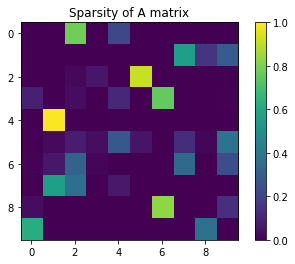

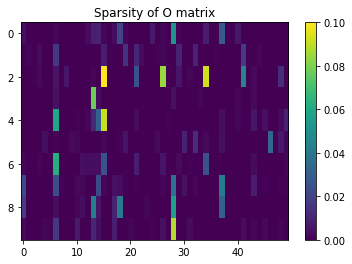

In [ ]:
visualize_sparsities(hmm10_meter, O_max_cols=50)

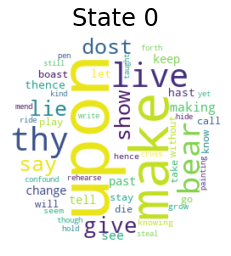

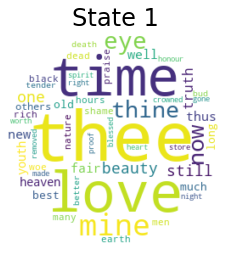

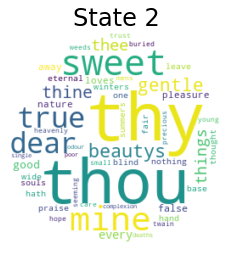

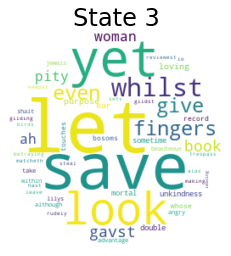

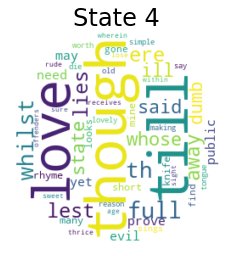

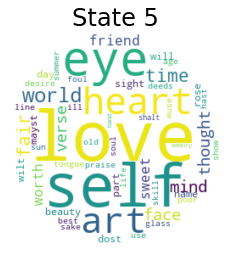

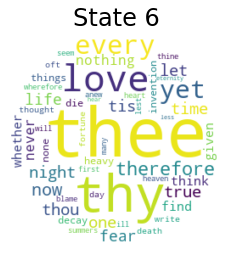

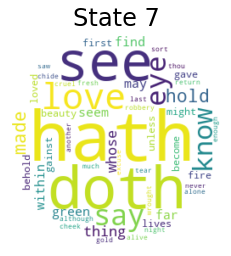

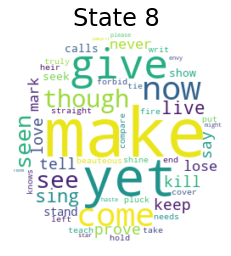

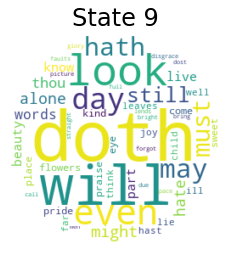

In [ ]:
wordclouds = states_to_wordclouds(hmm10_meter, obs_map)